In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500000

In [2]:
data = pd.read_csv('sorted_coded_data.csv')

#  Sleeptime distribution

I start by calculating the sleep time for each app. Here it corresponds to the time from when the user closed the last app, to he/she opened the current app.

In [3]:
user_groups=data.groupby('user_id')

In [4]:
data['sleep_time']=user_groups['end_time'].shift(1,fill_value=0.0)

In [6]:
data[data.start_time<data.sleep_time]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,3926.0
20,com.facebook.katana,0,28836,29777,941,19968,28906.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,54003.0
110,com.sonyericsson.video,0,173946,174206,260,45286,173976.0
111,com.sonyericsson.album,0,174036,174046,10,45260,174206.0
...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,29134004.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,29156994.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,29158899.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,29162955.0


As we can see here there is quit a few apps that are being used at least partially at the same time as other apps. This is indicated by the fact that the app is opened before the previous one is closed. For now we will consider this as zero sleep instances, but for further analysis it is worth considering that there if these should be considered as item sets, or sequences.

In [7]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  0.0
min sleep time:  78889680.0


In [5]:
data['sleep_time']=data['start_time']-data['sleep_time']

Here the probplem of overlapping app usage results in negative sleep times. For this analysis they will be considered as zero.

In [9]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  -59221.0
min sleep time:  7728262.0


In [6]:
data['sleep_time_modified']=data.sleep_time.copy()#[df < 0] = 0

In [7]:
data.sleep_time_modified[data['sleep_time_modified']<0]=0

<ipython-input-7-030ba3bc8cd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sleep_time_modified[data['sleep_time_modified']<0]=0


In [11]:
data[data.sleep_time<0]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,-237.0,0.0
20,com.facebook.katana,0,28836,29777,941,19968,-70.0,0.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,-210.0,0.0
110,com.sonyericsson.video,0,173946,174206,260,45286,-30.0,0.0
111,com.sonyericsson.album,0,174036,174046,10,45260,-170.0,0.0
...,...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,-287.0,0.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,-111.0,0.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,-20.0,0.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,-50.0,0.0


In [15]:
data.sleep_time_modified.quantile(q=0.99)

28363.0

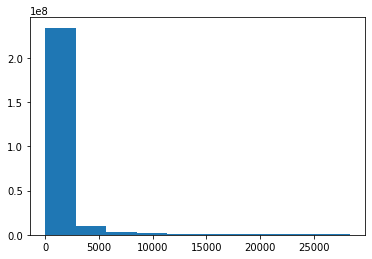

In [16]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=data.sleep_time_modified.quantile(q=0.99)])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

Again we see that most of the observations have a very low sleep time so we again constrict the interval of intrest. 

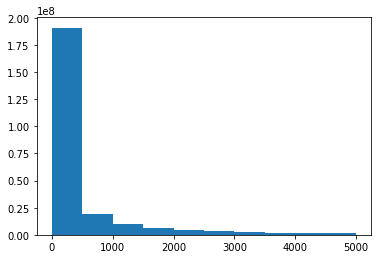

In [17]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=5000])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

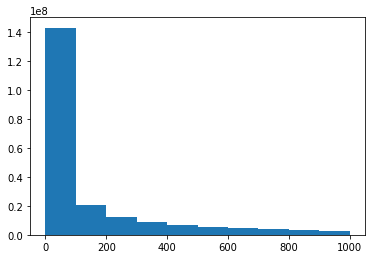

In [18]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=1000])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

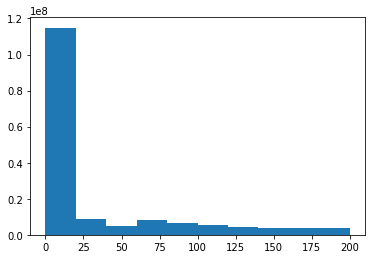

In [19]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=200])#, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)[so
plt.show()

# Opening the same data twice
Here we investigate the possiblity of opening the same data right after each other. As we are intrested in the patterns of usage it is not neccessarily of much intrest that you close an app and immediatly open it again to continue the same activity.

We start by the number of times the app which is opend is the same as the last one opened.

In [8]:
data["previous_app_code"]=user_groups.app_code.shift(1)

In [21]:
data.app_code[data.app_code==data.previous_app_code].count()

55448447

In [22]:
data.app_code[data.app_code==data.previous_app_code].count()/data.shape[0]*100

21.791454132467504

we now take all look at the sleeping times for these obervations

In [23]:
print("max sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].max())
print("min sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].min())

max sleep time:  6067204.0
min sleep time:  -23445.0


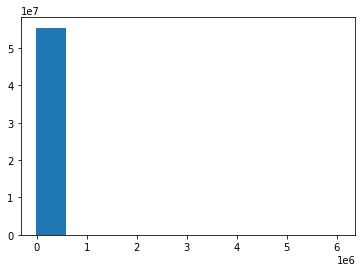

In [24]:
plt.hist(data.sleep_time[data.app_code==data.previous_app_code])
plt.show()

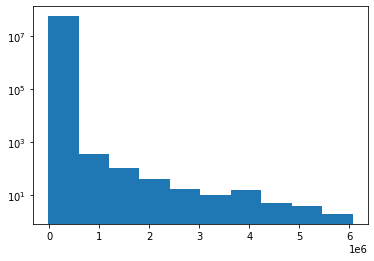

In [36]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code) ])#& (data.sleep_time<1000000)])
plt.yscale('log')
plt.show()

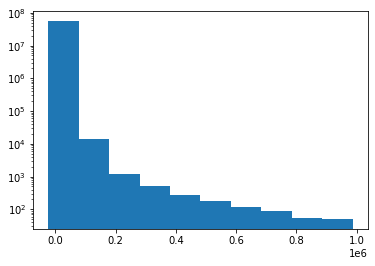

In [37]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<1000000)])
plt.yscale('log')
plt.show()

However we are esspecially interested in the ones used very close to each other.

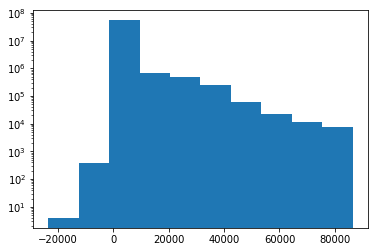

In [41]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)])
plt.yscale('log')
plt.show()

In [44]:
print("number of times the same app is opened while the app is in use: ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<0)].count())
print("number of times the same app is opened right after (sleep time 0): ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time==0)].count())

number of times the same app is opened while the app is in use:  4821
number of times the same app is opened right after (sleep time 0):  409933


We see that a small number is used at the same time. For our purpesis it is clear that these should be combined. Also we see that approcimately 400000 are opened imediatly after with no sleep time in between. For these it is also clear that they can be combined.

Since we now filter out the apps which overlap in use time.

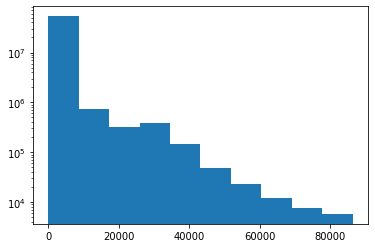

In [46]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)&(data.sleep_time>0)])
plt.yscale('log')
plt.show()

In [57]:
data.sleep_time[(data.app_code==data.previous_app_code)].mean()

1553.9468436329696

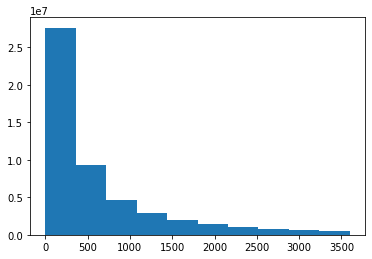

In [49]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60)&(data.sleep_time>0)])
plt.show()

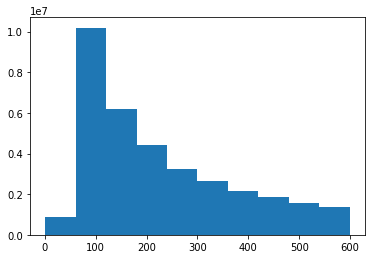

In [55]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<10*60)&(data.sleep_time>0)])
plt.show()

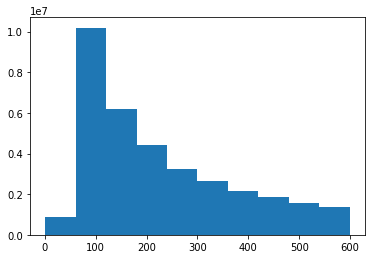

In [56]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<10*60)&(data.sleep_time>0)])
plt.show()

In [64]:
data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)].count()/data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)].count()

0.6278039527530889

Now we combine the observations where the same app is used again after a maximum of 10min sleep time.

In [65]:
data[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0
26,com.android.chrome,0,33229,33239,10,7649,460.0,460.0,7649.0
28,com.sonyericsson.album,0,33552,33562,10,45260,217.0,217.0,45260.0
46,com.sonyericsson.android.socialphonebook,0,48785,48795,10,45261,491.0,491.0,45261.0
...,...,...,...,...,...,...,...,...,...
254450388,com.whatsapp,9999,29163246,29163262,16,53003,217.0,217.0,53003.0
254450389,com.whatsapp,9999,29163490,29163500,10,53003,228.0,228.0,53003.0
254450399,com.facebook.katana,9999,29167795,29167859,64,19968,280.0,280.0,19968.0
254450405,com.snapchat.android,9999,29201485,29201495,10,44880,256.0,256.0,44880.0


In [37]:
data2.loc[list(data2[(data2.app_code==data2.previous_app_code)& (data2.sleep_time<=10*60)&(data2.sleep_time>0)].index-1),"end_time"]=data2.loc[list(data2[(data2.app_code==data2.previous_app_code)& (data2.sleep_time<=10*60)&(data2.sleep_time>0)].index),"end_time"].to_list()

In [41]:
data2.iloc[170:175,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
170,com.facebook.katana,0,244169,244579,410,19968,2818.0,2818.0,27441.0
171,com.android.chrome,0,244579,244699,120,7649,0.0,0.0,19968.0
172,com.facebook.katana,0,244980,245456,117,19968,281.0,281.0,7649.0
173,com.facebook.katana,0,245230,245625,226,19968,133.0,133.0,19968.0
174,com.facebook.katana,0,245529,245625,96,19968,73.0,73.0,19968.0


In [42]:
data.iloc[170:176,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
170,com.facebook.katana,0,244169,244579,410,19968,2818.0,2818.0,27441.0
171,com.android.chrome,0,244579,244699,120,7649,0.0,0.0,19968.0
172,com.facebook.katana,0,244980,245097,117,19968,281.0,281.0,7649.0
173,com.facebook.katana,0,245230,245456,226,19968,133.0,133.0,19968.0
174,com.facebook.katana,0,245529,245625,96,19968,73.0,73.0,19968.0
175,com.facebook.katana,0,250815,250825,10,19968,5190.0,5190.0,19968.0


In [10]:
data2=data.copy()

In [73]:
data2.iloc[70:80,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new event,event
70,com.android.chrome,0,87972,88283,311,7649,0.0,0.0,19968.0,False,0
71,com.android.chrome,0,88603,88663,60,7649,320.0,320.0,7649.0,False,0
72,com.acobot.en,0,88663,89439,776,6364,0.0,0.0,7649.0,False,0
73,com.android.chrome,0,90392,90472,80,7649,953.0,953.0,6364.0,False,0
74,bg.abv.andro.emailapp,0,90472,90505,33,2340,0.0,0.0,7649.0,False,0
75,bg.abv.andro.emailapp,0,90883,90893,10,2340,378.0,378.0,2340.0,False,0
76,com.adobe.reader,0,90893,90913,20,6577,0.0,0.0,2340.0,False,0
77,com.facebook.katana,0,114805,115214,409,19968,23892.0,23892.0,6577.0,False,0
78,com.android.chrome,0,115224,115407,183,7649,10.0,10.0,19968.0,False,0
79,com.facebook.katana,0,115417,116023,606,19968,10.0,10.0,7649.0,False,0


In [61]:
data[data.sleep_time>60*60*10]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
385,com.facebook.katana,0,553773,553783,10,19968,36221.0,36221.0,27441.0
511,com.facebook.katana,0,811606,811622,16,19968,36432.0,36432.0,7649.0
914,com.facebook.katana,0,1418069,1418430,361,19968,51247.0,51247.0,51657.0
1939,com.facebook.katana,0,2968957,2969570,613,19968,36639.0,36639.0,2340.0
2033,com.sonyericsson.album,0,3184242,3184262,20,45260,110175.0,110175.0,19968.0
...,...,...,...,...,...,...,...,...,...
254450022,com.microsoft.office.outlook,9999,28681847,28681998,151,33357,38475.0,38475.0,45260.0
254450110,com.facebook.katana,9999,28767044,28767084,40,19968,40359.0,40359.0,44880.0
254450159,com.whatsapp,9999,28854435,28854445,10,53003,36221.0,36221.0,45260.0
254450190,com.whatsapp,9999,28946850,28947080,230,53003,37963.0,37963.0,45284.0


# combine again

In [13]:
data2=data.copy()

For all app usages that should be merged together, the indexes of those with the highest end time.\
This mean that we are only interested in obervertions that need to be merged so the first step is to filter the data according to this criteria.

In [14]:
data2=data2[(data2.previous_app_code==data2.app_code) | (data2.app_code==data2.app_code.shift(-1))]

We now identify which belong to the same event. This is done in order to accomendate situation where the same app is used more than twice in a row.\
Insperation for this part of the solution was found here: https://stackoverflow.com/questions/38885770/weather-events-grouped-based-on-time-differences-in-pandas (visited 24.9.2021)

In [92]:
data2

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event
6,com.whatsapp,0,1712,1788,76,53003,0.0,0.0,23967.0,False,0
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0,False,0
8,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,False,0
13,com.whatsapp,0,4076,4156,80,53003,0.0,0.0,7649.0,False,0
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...
254450399,com.facebook.katana,9999,29167795,29167859,64,19968,280.0,280.0,19968.0,False,4
254450404,com.snapchat.android,9999,29201197,29201229,32,44880,0.0,0.0,27441.0,False,3
254450405,com.snapchat.android,9999,29201485,29201495,10,44880,256.0,256.0,44880.0,False,3
254450407,com.facebook.orca,9999,29201785,29201793,8,19973,0.0,0.0,19968.0,False,10


In [15]:
data2['new_event'] = data2.groupby(['user_id','app_code']).sleep_time.apply(lambda s: s>60*60*10)

In [16]:
data2.loc[data2[data2.app_code!=data2.previous_app_code].index,'new_event'] = True

In [18]:
data2['event'] = data2.groupby(['user_id','app_code']).new_event.cumsum().astype('int')

In [107]:
data2[data2.package_name=="com.whatsapp"].iloc[0:30,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event
6,com.whatsapp,0,1712,1788,76,53003,0.0,0.0,23967.0,True,1
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0,False,1
8,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,False,1
13,com.whatsapp,0,4076,4156,80,53003,0.0,0.0,7649.0,True,2
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0,False,2
120,com.whatsapp,0,175736,175916,180,53003,0.0,0.0,7649.0,True,3
121,com.whatsapp,0,176086,176166,80,53003,170.0,170.0,53003.0,False,3
133,com.whatsapp,0,177236,177267,31,53003,-141.0,0.0,7649.0,True,4
134,com.whatsapp,0,177377,177567,190,53003,110.0,110.0,53003.0,False,4
136,com.whatsapp,0,178561,178581,20,53003,1044.0,1044.0,19968.0,True,5


We are now ready to identify the indexes of the highest end time for each event.\
Insperation for this part of the solution was found here: https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby (visited 24.9.2021)

In [31]:
data2_grouped = data2.groupby(['user_id', 'app_code','event']).agg({'end_time':'max'})
data2_grouped

end_time
user_id app_code event          
0       2262     1       1948314
                 2       2619637
                 3       3742172
                 4       4543258
                 5       5920747
...                          ...
9999    53003    409    29145185
                 410    29163500
        66136    1      12129155
                 2      12129600
                 3      21274142

[36205739 rows x 1 columns]

In [32]:
data2_grouped = data2_grouped.reset_index()
data2_grouped

,user_id,app_code,event,end_time
0,0,2262,1,1948314
1,0,2262,2,2619637
2,0,2262,3,3742172
3,0,2262,4,4543258
4,0,2262,5,5920747
...,...,...,...,...
36205734,9999,53003,409,29145185
36205735,9999,53003,410,29163500
36205736,9999,66136,1,12129155
36205737,9999,66136,2,12129600


In [33]:
data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})
data2_grouped

,user_id,app_code,event,event_end_time
0,0,2262,1,1948314
1,0,2262,2,2619637
2,0,2262,3,3742172
3,0,2262,4,4543258
4,0,2262,5,5920747
...,...,...,...,...
36205734,9999,53003,409,29145185
36205735,9999,53003,410,29163500
36205736,9999,66136,1,12129155
36205737,9999,66136,2,12129600


In [34]:
data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'app_code','event'])
data3

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event,event_end_time
0,com.whatsapp,0,1712,1788,76,53003,0.0,0.0,23967.0,True,1,3579
1,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0,False,1,3579
2,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,False,1,3579
3,com.whatsapp,0,4076,4156,80,53003,0.0,0.0,7649.0,True,2,4742
4,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0,False,2,4742
...,...,...,...,...,...,...,...,...,...,...,...,...
91439239,com.facebook.katana,9999,29167795,29167859,64,19968,280.0,280.0,19968.0,False,63,29167859
91439240,com.snapchat.android,9999,29201197,29201229,32,44880,0.0,0.0,27441.0,True,16,29201495
91439241,com.snapchat.android,9999,29201485,29201495,10,44880,256.0,256.0,44880.0,False,16,29201495
91439242,com.facebook.orca,9999,29201785,29201793,8,19973,0.0,0.0,19968.0,True,189,29202128


In [36]:
data3 = data3[data3['end_time'] == data3['event_end_time']]
data3

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event,event_end_time
2,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,False,1,3579
4,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0,False,2,4742
6,com.google.android.youtube,0,32091,32101,10,23967,2142.0,2142.0,23967.0,False,1,32101
8,com.android.chrome,0,33229,33239,10,7649,460.0,460.0,7649.0,False,1,33239
10,com.sonyericsson.album,0,33552,33562,10,45260,217.0,217.0,45260.0,False,1,33562
...,...,...,...,...,...,...,...,...,...,...,...,...
91439235,com.whatsapp,9999,29163490,29163500,10,53003,228.0,228.0,53003.0,False,410,29163500
91439237,com.facebook.katana,9999,29165807,29165843,36,19968,2258.0,2258.0,19968.0,False,62,29165843
91439239,com.facebook.katana,9999,29167795,29167859,64,19968,280.0,280.0,19968.0,False,63,29167859
91439241,com.snapchat.android,9999,29201485,29201495,10,44880,256.0,256.0,44880.0,False,16,29201495


In [58]:
data3=data3.drop_duplicates(subset=['user_id', 'app_code','event'], keep='last')

In [59]:
data3.loc[23919450:23919460,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event,event_end_time
23919450,com.pof.android,2607,9808383,9808413,30,40018,210.0,210.0,40018.0,False,382,9808413
23919453,com.pof.android,2607,9809414,9809454,40,40018,390.0,390.0,40018.0,False,383,9809454
23919455,com.facebook.katana,2607,9855519,9855559,40,19968,7041.0,7041.0,19968.0,False,166,9855559
23919456,com.sonyericsson.android.socialphonebook,2607,9862840,9863040,200,45261,1001.0,1001.0,53003.0,True,55,9863040
23919459,com.sonyericsson.android.socialphonebook,2607,9863351,9863551,200,45261,-200.0,0.0,45261.0,False,56,9863551


In [50]:
data3.drop_duplicates(subset=['user_id', 'app_code','event'], take_last=Last).iloc[23919450:23919469]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event,event_end_time
23919458,com.sonyericsson.android.socialphonebook,2607,9863340,9863551,211,45261,320.0,320.0,7653.0,True,56,9863551
23919459,com.sonyericsson.android.socialphonebook,2607,9863351,9863551,200,45261,-200.0,0.0,45261.0,False,56,9863551


In [43]:
test=data3.groupby(['user_id','app_code','event']).agg({'end_time':'count'})
test[test.end_time>1]

end_time
user_id app_code event          
2607    45261    56            2
2864    11779    928           2
3338    2262     400           2
        23949    1000          2
3635    23947    45            2
5211    7653     25            2
                 135           2
5277    7653     6             2
5584    62161    200           2
5864    19968    216           2
6559    7151     114           2
7529    19968    7             2
7849    19968    1713          2
8201    7649     57            2
8839    50519    21            2
8890    7653     2             2
        31664    38            2
        45264    306           2
9346    19968    492           2
9462    19973    832           2

In [46]:
data2[(data2.user_id==2607)&(data2.app_code==45261)&(data2.event==56)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event
66289786,com.sonyericsson.android.socialphonebook,2607,9863340,9863551,211,45261,320.0,320.0,7653.0,True,56
66289787,com.sonyericsson.android.socialphonebook,2607,9863351,9863551,200,45261,-200.0,0.0,45261.0,False,56


We see that 

number of combined events:  36205739\
number of found min indices:  36205807\
number of found max indices:  36205759

In [60]:
data2_grouped = data2.groupby(['user_id', 'app_code','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'app_code','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['user_id', 'app_code','event'], keep='last')

We now have the index of the end times for the ones that need to be combined,

In [61]:
max_index=data2.iloc[data3.index].index

We now need to find the index of the lowest start time within each of the events, that needs to be combined.

In [63]:
data2_grouped = data2.groupby(['user_id', 'app_code','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'app_code','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['user_id', 'app_code','event'], keep='last')

In [64]:
min_index=data2.iloc[data3.index].index

As a sanity check we count the number of combined events, the number of min indices and the number of max indices, as they all three should be the same.

In [65]:
print("number of combined events: ",data2.groupby(['user_id','app_code']).agg({"event": "nunique"}).event.sum())
print("number of found min indices: ",len(min_index))
print("number of found max indices: ",len(max_index))

number of combined events:  36205739
number of found min indices:  36205739
number of found max indices:  36205739


The observations can now be updated.

In [91]:
data3=data.copy()

In [94]:
data3.loc[min_index,"end_time"]=data3.loc[max_index].set_index(min_index).end_time

In [95]:
data3=data3.drop(set(data2.index)-set(min_index))

In [96]:
data3

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0
...,...,...,...,...,...,...,...,...,...
254450417,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,185.0,185.0,19968.0
254450418,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0
254450419,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0
254450420,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,5890.0,5890.0,23875.0


In [100]:
len(data.index)-(len(data2.index)-len(min_index))==len(data3.index)

True

Then the sleep time spend is updated, as well as the sleep time is updated and the previous app code

In [108]:
data3['time_spend']=data3['end_time']-data3['start_time']

In [109]:
user_groups=data3.groupby('user_id')

In [110]:
data3['sleep_time']=user_groups['end_time'].shift(1,fill_value=0.0)
data3['sleep_time']=data3['sleep_time']-data3.start_time

In [111]:
data3[data3.sleep_time_modified<0].sleep_time_modified=0

In [112]:
data3['previous_app_code']=data3.app_code.shift(1)

now the index is reset

In [117]:
data3=data3.reset_index(drop=True)

In [120]:
data3.to_csv("sorted_coded_data_with_merged_events_10_min.csv",index=False)

We now look at the updated numbers for the same app used right after each.

In [128]:
print("Number of same number of apps after the same app: ",data3.app_code[data3.app_code==data3.previous_app_code].count())
print("Procent of apps which are the same as the previous: ",data3.app_code[data3.app_code==data3.previous_app_code].count()/len(data3.app_code)*100)

Number of same number of apps after the same app:  215438
Procent of apps which are the same as the previous:  0.10814242246304816


We see that now less than 1% of the the observations represent the same apps.

# Use time of apps.
Part of the intrest in use times is that if we are intrested in understanding how we use apps, it can cloud the overall image to look at something which might be for instance is opened by mistake, here can the use times for instance be an indication if for instance an app is only opened for a second, then the user will not actualy interact with the app.

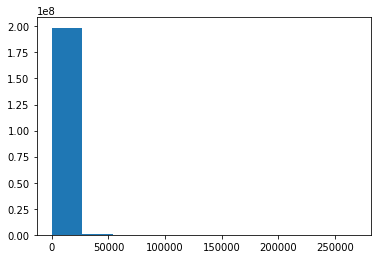

In [134]:
plt.hist(data3.time_spend)
plt.show()

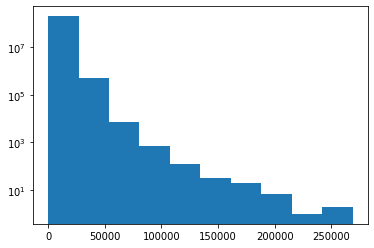

In [135]:
plt.hist(data3.time_spend)
plt.yscale('log')
plt.show()

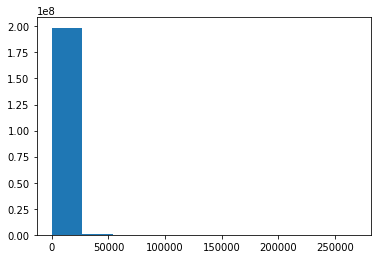

In [137]:
bins=plt.hist(data3.time_spend)

In [138]:
bins

(array([1.98718922e+08, 4.90122000e+05, 7.00300000e+03, 6.77000000e+02,
        1.30000000e+02, 3.30000000e+01, 2.00000000e+01, 7.00000000e+00,
        1.00000000e+00, 2.00000000e+00]),
 array([1.000000e+00, 2.686410e+04, 5.372720e+04, 8.059030e+04,
        1.074534e+05, 1.343165e+05, 1.611796e+05, 1.880427e+05,
        2.149058e+05, 2.417689e+05, 2.686320e+05]),
 <BarContainer object of 10 artists>)

In [ ]:
plt.hist(data3.time_spend)
plt.yscale('log')
plt.show()

# Updated sleep distribution